# Sparkify (Music Streaming Service)
### by Nima Sayyah


<div>
<img src="Sparkify.jpeg" width="600"/>
</div>



## Table of Contents
* [Introduction](#int)
* [Data Wrangling](#load)
* [Exploratory Data Analysis](#eda)
* [Feature Engineering](#eng)
* [Modelling](#model)
* [Conclusions](#con)

### Introduction
<a class="anchor" id="int"></a>

This project will take advantage of a music app dataset similar to Spotify platform. It will use Spark to extract relevant features for predicting churn. Churn signifies the service termination. Spotting customers before they churn, the business can offer discounts and incentives for their retention to stabilise the business revenue. This workspace contains a subset (128MB) of the full dataset available (12GB).

In [38]:
# Importing necessary libraries
import pyspark 
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql.functions import *

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, PCA, RegexTokenizer, VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime
import time

import pandas as pd
import numpy as np
import re
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Craeting a Spark session
spark = SparkSession.builder.appName("Sparkify Project").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/07/09 23:32:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
spark.sparkContext.getConf().getAll()

[('spark.app.startTime', '1657405972143'),
 ('spark.driver.extraJavaOptions',
  '-XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED'),
 ('spark.driver.port', '52349'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.host', 'snmp.lan'),
 ('spark.rdd.compress', 'True'),
 ('spark.executor.extraJavaOptions',
  '-XX:+IgnoreUnr

### Data Wrangling
<a class="anchor" id="load"></a>
At this stage the data`mini_sparkify_event_data.json` is loaded processed and cleaned. 

In [7]:
# loading the dataset
df = spark.read.json("mini_sparkify_event_data.json")

In [8]:
# Printing the schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [9]:
# Computing basic statistics or information
df.summary()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [10]:
# Taking the first two element of the RDD Dataset
df.take(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

In [11]:
# The count of the dataset before cleaning 
df.count()

286500

### Drop Rows with Missing Values

It is reasonble to first explore missing values for ID related cells.

In [12]:
# Dropping rows with missing values in userid and/or sessionid
df = df.dropna(how = 'any', subset = ["userId", "sessionId"])

In [13]:
# Recounting the dataset
df.count()

286500

It appears there are no missing values. We however need further analysis. 

In [14]:
# Removing userId duplicates
df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



As it can be seen there are empty strings used as **userId**. We proceed by removing those empty strings.

In [15]:
# Removing empty string userIds
df = df.filter(df["userId"] != "")

In [16]:
df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
|100018|
+------+
only showing top 20 rows



In [17]:
# Removing sessionId duplicates
df.select("sessionId").dropDuplicates().sort("sessionId").show()

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



In [18]:
# Recounting the dataset
df.count()

278154

This means we have dropped **286500** - **278154** = **8346** at this stage

In [19]:
# Exploring the dataset by Panda Dataframe 
df_pandas = df.toPandas()
df_pandas

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278149,Iron Maiden,Logged In,Emilia,F,38,House,258.66404,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,NextSong,1538336771000,500,Murders In The Rue Morgue (1998 Digital Remaster),200,1543622121000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011
278150,None,Logged In,Emilia,F,39,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,Logout,1538336771000,500,None,307,1543622122000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011
278151,None,Logged In,Emilia,F,43,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",GET,Home,1538336771000,500,None,200,1543622248000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011
278152,None,Logged In,Emilia,F,44,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",GET,About,1538336771000,500,None,200,1543622398000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011


## Exploratory Data Analysis
<a class="anchor" id="eda"></a>

At this section we will explore the actions taken by the users who churned versus those who stayed with the service. For that pupose, we have certain columnar information, such as the `length` and the `song`, to take the analysis forward.


### Churn Column

As explained in the introduction, **Churn** is defined as the service termination. Therfore, a column `Churn` will be created. `page` column is used to extract those labelled as `Cancellation Confirmation` and assign to those who churned. This is applied for both free and paid users. We will assign a **0** where a user has not churned and a **1** where they have churned.


In [20]:
# Exploring the page column classifications
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



As explained earlier, `Cancelalation Confirmation` identifies the users who confirmed termination from the service.

In [21]:
# Exploring those who churned 
df.select(["userId", "page"]).where(df.page == "Cancellation Confirmation").show()

+------+--------------------+
|userId|                page|
+------+--------------------+
|    18|Cancellation Conf...|
|    32|Cancellation Conf...|
|   125|Cancellation Conf...|
|   105|Cancellation Conf...|
|    17|Cancellation Conf...|
|   143|Cancellation Conf...|
|   101|Cancellation Conf...|
|   129|Cancellation Conf...|
|   121|Cancellation Conf...|
|    51|Cancellation Conf...|
|    87|Cancellation Conf...|
|   122|Cancellation Conf...|
|    12|Cancellation Conf...|
|    58|Cancellation Conf...|
|    73|Cancellation Conf...|
|     3|Cancellation Conf...|
|   106|Cancellation Conf...|
|   103|Cancellation Conf...|
|    28|Cancellation Conf...|
|    54|Cancellation Conf...|
+------+--------------------+
only showing top 20 rows



In [22]:
# Identifying how many users churned 
df.select(["userId", "page"]).where(df.page == "Cancellation Confirmation").count()

52

Therefore, **52** users churned. 

We can now proceed to creating a flag for identifying churned and unchurned users. For this we assign the churned users to **1** and otherwise **0**.

In [23]:
# Using User Defined Function to flag the users in a new column
churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("Churn", churn_event("page"))
df.select(["userId", "Churn"]).show()

+------+-----+
|userId|Churn|
+------+-----+
|    30|    0|
|     9|    0|
|    30|    0|
|     9|    0|
|    30|    0|
|     9|    0|
|     9|    0|
|    30|    0|
|    30|    0|
|    30|    0|
|     9|    0|
|     9|    0|
|    30|    0|
|     9|    0|
|     9|    0|
|    30|    0|
|     9|    0|
|    74|    0|
|    30|    0|
|     9|    0|
+------+-----+
only showing top 20 rows



In [24]:
df.select(["userId", "Churn"]).where(df.Churn == 1 ).show()

+------+-----+
|userId|Churn|
+------+-----+
|    18|    1|
|    32|    1|
|   125|    1|
|   105|    1|
|    17|    1|
|   143|    1|
|   101|    1|
|   129|    1|
|   121|    1|
|    51|    1|
|    87|    1|
|   122|    1|
|    12|    1|
|    58|    1|
|    73|    1|
|     3|    1|
|   106|    1|
|   103|    1|
|    28|    1|
|    54|    1|
+------+-----+
only showing top 20 rows



As it can be seen in the last cell, the `Churn` column has been created with the assigned values of **1** and **0**.

In [25]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
windowval

In [26]:
df = df.withColumn("churn", Fsum("churn").over(windowval))
df.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|                null|Logged In|  Bryanna|     F|           43|   Stone|     null| free|Los Angeles-Long ...|   PUT|     Logout|1537440271000|      201|                null|   307|1543335219000|Mozilla/5.0 (Maci...|100008|    0|
|Bembeya Jazz Nati...|Logged In|  Bryanna|     F|           42|   Stone|245.99465| f

In [45]:
df_churn = df.select(['userId', 'churn']).dropDuplicates().groupBy('churn').count()
df_churn.show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|    1|
|    1|    1|
+-----+-----+



### EDA for Users that Stayed vs Users that Churned

Now we can examine behaviour of those who churned vs those who did not churn. First we will visualise those who churned vs those who stayed.

In [41]:
df_churn = df_churn.toPandas()
df_churn

,churn,count
0,0,173
1,1,52


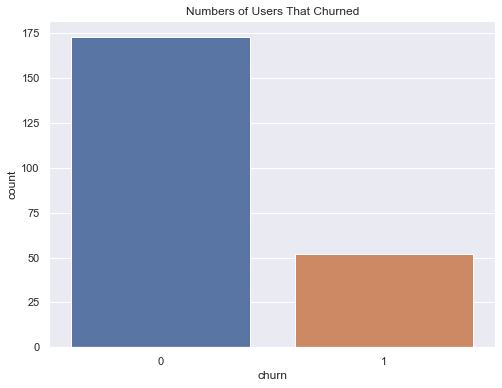

In [42]:
plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_churn, x = 'churn', y='count')
plt.title("Numbers of Users That Churned");

In [43]:
52/(173+52) * 100

23.11111111111111

From the above, we can see that 173 users stayed while 52 users churned. Therefore this means that 23% of our users churned. It is important to note moving forward that this is an imbalance.

### Length of time: Users that Churned vs. Users that Stayed

We can now look at the length distribution for customers who stayed and those which churned. 

In [ ]:
df_len = df.filter(df.churn ==1)

In [ ]:
df_pd = df_len.toPandas()

In [ ]:
df_pd.length.dropna(inplace=True)

In [ ]:
bin_edges = np.arange (10, df_pd['length'].max()+25, 25)
plt.hist(data = df_pd, x = 'length', bins = bin_edges)
plt.xlim(0,700)
plt.xlabel('Length')
plt.ylabel('Frequency');

In [ ]:
df_len_stay = df.filter(df.churn ==0)

In [ ]:
df_pd = df_len_stay.toPandas()

In [ ]:
df_pd.length.dropna(inplace=True)

In [ ]:
bin_edges = np.arange (10, df_pd['length'].max()+25, 25)
plt.hist(data = df_pd, x = 'length', bins = bin_edges)
plt.xlim(0,700)
plt.xlabel('Length')
plt.ylabel('Frequency');